In [1]:
# Autoreload ensures that your python-files stay up-to-date: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Move back to the root directory
%cd ..

/workspaces/seminars_as_branches


/opt/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Custom datasets

This notebook shows how we're going to create custom PyTorch datasets, that fit our problem. A good reference is this [PyTorch tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [2]:
import json
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from numpy.typing import NDArray
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

## Simple dataset

First, we're going to create the most simple version of the dataset.

**Questions:**
* **What is the purpose of a custom dataset?**
* **What are the benefits of a PyTorch Dataset?**
* **What are things to watch out for?**

In [3]:
class MinifiguresDataset(Dataset):
    """Custom dataset."""

    def __init__(self, data_f: Path, dataset: dict[str, list[str]]) -> None:
        """
        Initialise the dataset.

        Parameters
        ----------
        data_f : Path
            Path to the data (images) folder
        dataset : dict[str,list[str]]
            Dictionary containing the dataset and target data
        """
        self.data_f = data_f
        self.keys, self.labels = zip(*dataset.items())

    def __len__(self) -> int:
        """Amount of images within the dataset."""
        return len(self.keys)

    def __getitem__(self, idx: int) -> dict[str, Any]:
        """Load in the first next item from our dataset."""
        img = np.asarray(Image.open(self.data_f / f"{self.keys[idx]}.png").convert("RGB"))
        label = self.labels[idx]

        return {"image": img, "label": label}

In [4]:
# Create the dataset
with open(Path.cwd() / "data/data/datasets/val.json") as f:
    dataset_json = json.load(f)
dataset = MinifiguresDataset(data_f=Path("data/data/minifigures"), dataset=dataset_json)
len(dataset)

23

dict_keys(['image', 'label'])


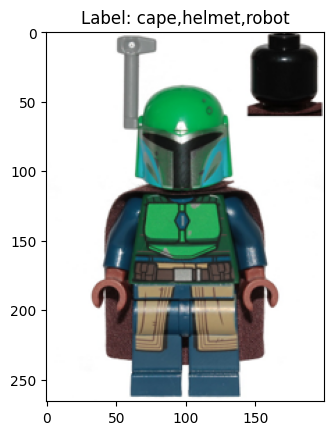

In [5]:
# Show one sample
sample = dataset[0]
print(sample.keys())

plt.figure()
plt.title(f"Label: {','.join(sample['label'])}")
plt.imshow(sample["image"])
plt.show()

## Problem 1: Multi-hot encoding for labels

Models only understand numbers, convert the labels (strings) into integers!

In [7]:
class MinifiguresDataset(Dataset):
    """Custom dataset."""

    def __init__(self, data_f: Path, dataset: dict[str, list[str]]) -> None:
        """
        Initialise the dataset.

        Parameters
        ----------
        data_f : Path
            Path to the data (images) folder
        dataset : dict[str,list[str]]
            Dictionary containing the dataset and target data
        """
        self.data_f = data_f
        self.keys, self.labels = zip(*dataset.items())

        # TODO: Add the classes
        self.classes = sorted({x for y in self.labels for x in y})

    def __len__(self) -> int:
        """Amount of images within the dataset."""
        return len(self.keys)

    def __getitem__(self, idx: int) -> dict[str, Any]:
        """Load in the first next item from our dataset."""
        img = np.asarray(Image.open(self.data_f / f"{self.keys[idx]}.png").convert("RGB"))

        # TODO: Create multi-hot encoded labels
        # Multi-hot encode the labels
        label = torch.FloatTensor([x in self.labels[idx] for x in self.classes])

        return {"image": img, "label": label}

In [8]:
# Create the dataset
dataset = MinifiguresDataset(data_f=Path("data/data/minifigures"), dataset=dataset_json)
len(dataset)

23

dict_keys(['image', 'label'])


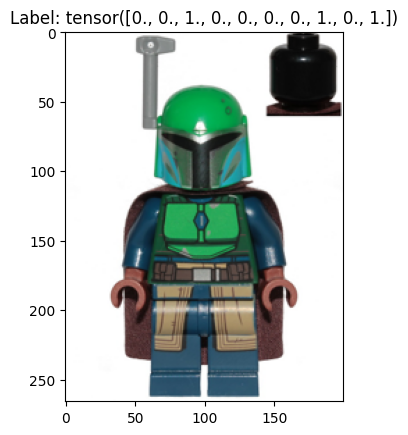

In [9]:
# Show one sample
sample = dataset[0]
print(sample.keys())

plt.figure()
plt.title(f"Label: {sample['label']}")
plt.imshow(sample["image"])
plt.show()

## Problem 2: Varying image sizes

You cannot stack images that have a different size.

In [10]:
dataloader = DataLoader(dataset, batch_size=16)
batch = next(iter(dataloader))

/opt/venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


RuntimeError: stack expects each tensor to be equal size, but got [266, 200, 3] at entry 0 and [218, 200, 3] at entry 3

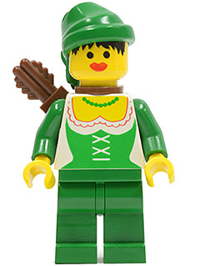

In [11]:
# Open an example image first
example = Image.open(Path.cwd() / "data/data/minifigures/cas319.png")
example

torch.Size([266, 200, 3])
torch.float32
tensor(0.) tensor(255.) tensor(186.6923) tensor(88.0980)


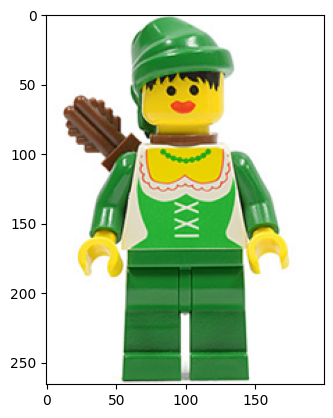

In [12]:
# Create a function that transforms the image to a PyTorch tensor
def to_tensor(x: torch.Tensor | NDArray[np.float32] | Image.Image) -> torch.Tensor:
    """Convert to tensor."""
    if isinstance(x, torch.Tensor):
        return x
    if isinstance(x, np.ndarray):
        return torch.Tensor(x)
    if isinstance(x, Image.Image):
        return torch.Tensor(np.array(x))
    raise Exception(f"Variable of type '{type(x)}' not supported!")


example = to_tensor(example)
print(example.shape)
print(example.dtype)
print(example.min(), example.max(), example.mean(), example.std())

plt.figure()
plt.imshow(example.detach().numpy() / 255)
plt.show()

torch.Size([3, 266, 200])
torch.float32
tensor(0.) tensor(1.) tensor(0.7321) tensor(0.3455)


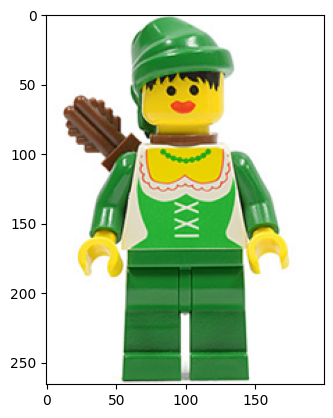

In [13]:
# Make image channel first and normalized
example = example.permute(2, 0, 1) / 255.0
print(example.shape)
print(example.dtype)
print(example.min(), example.max(), example.mean(), example.std())

plt.figure()
plt.imshow(example.detach().numpy().transpose(1, 2, 0))
plt.show()

torch.Size([3, 266, 200])
torch.float32
tensor(0.) tensor(1.) tensor(0.7321) tensor(0.3455)


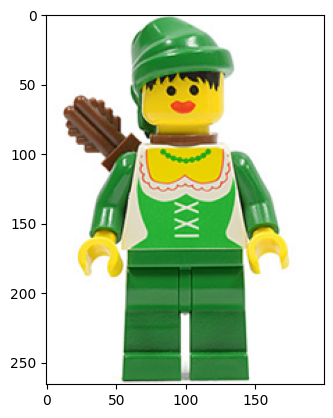

In [14]:
# Wrap everything into a single function
def load_img(path: Path) -> torch.Tensor:
    """Load the image specified under the provided path."""
    # Read in the image
    im = Image.open(path).convert("RGB")

    # Transform to tensor
    im = to_tensor(im)

    # Make image channel first and normalized
    return im.permute(2, 0, 1) / 255.0


example = load_img(Path.cwd() / "data/data/minifigures/cas319.png")
print(example.shape)
print(example.dtype)
print(example.min(), example.max(), example.mean(), example.std())

plt.figure()
plt.imshow(example.detach().numpy().transpose(1, 2, 0))
plt.show()

torch.Size([3, 266, 266])
torch.float32
tensor(0.) tensor(1.) tensor(0.7986) tensor(0.3211)


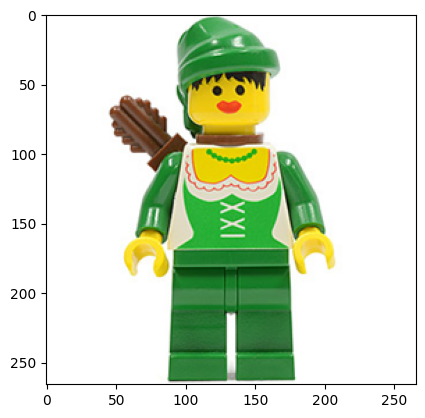

In [15]:
# Pad the image into a square
class SquarePad:
    """Pad the provided image to become a square, assumes channel-first."""

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """Pad the provided image to become a square."""
        _, _, h, w = x.shape  # batch_size, channels, width, height
        max_wh = max(w, h)
        p_left, p_right = ((max_wh - w) // 2 for _ in range(2))
        p_right += int(w % 2 == 1)
        p_bottom, p_top = ((max_wh - h) // 2 for _ in range(2))
        p_top += int(h % 2 == 1)
        padding = (p_left, p_right, p_top, p_bottom)
        return F.pad(x, padding, value=1, mode="constant")


pad = SquarePad()
example = pad(example[None,])[0]
print(example.shape)
print(example.dtype)
print(example.min(), example.max(), example.mean(), example.std())

plt.figure()
plt.imshow(example.detach().numpy().transpose(1, 2, 0))
plt.show()

torch.Size([3, 256, 256])
torch.float32
tensor(0.) tensor(1.) tensor(0.7986) tensor(0.3186)


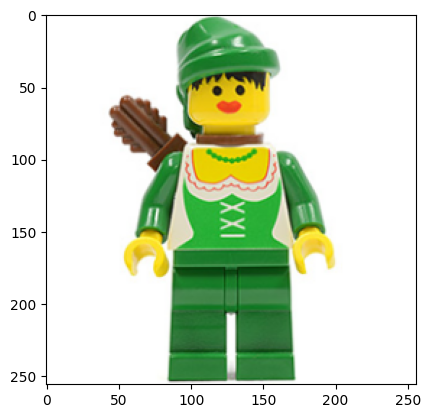

In [16]:
# Create a function that transforms the data into a fixed size
def get_transform_resize(resolution: int) -> torch.Tensor:
    """
    Transform a tensor to a fixed size.

    Parameters
    ----------
    resolution : int
        Resolution to transform to

    Returns
    -------
    torch.Tensor
        Resized image
    """
    return transforms.Compose([SquarePad(), transforms.Resize((resolution, resolution))])


# Transform the image
transform_resize = get_transform_resize(256)
example = load_img(Path.cwd() / "data/data/minifigures/cas319.png")
example = transform_resize(example[None,])[0]
print(example.shape)
print(example.dtype)
print(example.min(), example.max(), example.mean(), example.std())

plt.figure()
plt.imshow(example.detach().numpy().transpose(1, 2, 0))
plt.show()

torch.Size([3, 32, 32])
torch.float32
tensor(0.0011) tensor(1.) tensor(0.7960) tensor(0.3201)


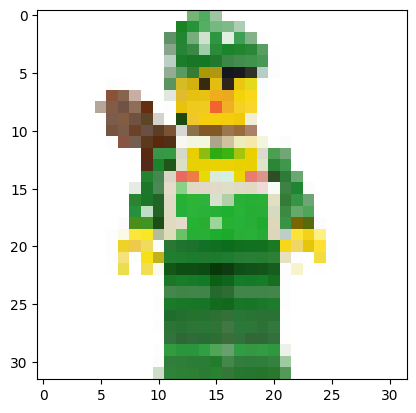

In [17]:
# Try for another resolution
transform_resize = get_transform_resize(32)
example = load_img(Path.cwd() / "data/data/minifigures/cas319.png")
example = transform_resize(example[None,])[0]
print(example.shape)
print(example.dtype)
print(example.min(), example.max(), example.mean(), example.std())

plt.figure()
plt.imshow(example.detach().numpy().transpose(1, 2, 0))
plt.show()

In [18]:
# Apply the changes to the dataset
class MinifiguresDataset(Dataset):
    """Custom dataset."""

    def __init__(self, data_f: Path, dataset: dict[str, list[str]], resolution: int = 256) -> None:
        """
        Initialise the dataset.

        Parameters
        ----------
        data_f : Path
            Path to the data (images) folder
        dataset : dict[str,list[str]]
            Dictionary containing the dataset and target data
        resolution : int
            Resolution to transform the images to
        """
        self.data_f = data_f
        self.keys, self.labels = zip(*dataset.items())
        self.classes = sorted({x for y in self.labels for x in y})

        # TODO: Specify a fixed resolution
        self.transform_resize = get_transform_resize(resolution)

    def __len__(self) -> int:
        """Amount of images within the dataset."""
        return len(self.keys)

    def __getitem__(self, idx: int) -> dict[str, Any]:
        """Load in the first next item from our dataset."""
        # TODO: Apply the changes introduced above
        # Load in the image as a tensor
        img = load_img(self.data_f / f"{self.keys[idx]}.png")

        # Reshape the a fixed size
        img = self.transform_resize(img[None,])[0]

        # Multi-hot encode the labels
        label = torch.FloatTensor([x in self.labels[idx] for x in self.classes])

        return {"image": img, "label": label}

In [19]:
# Create the dataset
dataset = MinifiguresDataset(data_f=Path("data/data/minifigures"), dataset=dataset_json)
len(dataset)

# Load a batch of images
dataloader = DataLoader(dataset, batch_size=16)
batch = next(iter(dataloader))
batch["image"].shape, batch["label"].shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 10]))

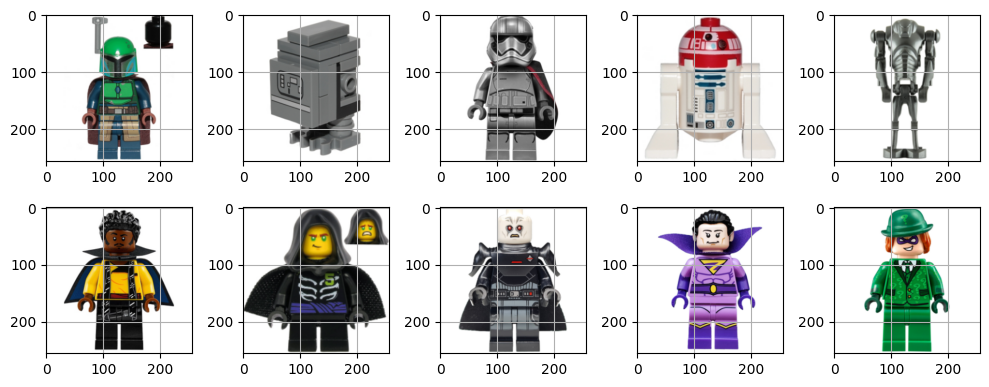

In [20]:
_, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(batch["image"][i].permute(1, 2, 0))
    ax.grid(True)
plt.tight_layout()
plt.show()

## Final dataset

The following code cell shows the final dataset.

**Question: What are the lessons learned?**

In [ ]:
class MinifiguresDataset(Dataset):
    """Custom dataset."""

    def __init__(self, data_f: Path, dataset: dict[str, list[str]], resolution: int = 256) -> None:
        """
        Initialise the dataset.

        Parameters
        ----------
        data_f : Path
            Path to the data (images) folder
        dataset : dict[str,list[str]]
            Dictionary containing the dataset and target data
        resolution : int
            Resolution to transform the images to
        """
        self.data_f = data_f
        self.keys, self.labels = zip(*dataset.items())
        self.classes = sorted({x for y in self.labels for x in y})
        self.transform_resize = get_transform_resize(resolution)

    def __len__(self) -> int:
        """Amount of images within the dataset."""
        return len(self.keys)

    def __getitem__(self, idx: int) -> dict[str, Any]:
        """Load in the first next item from our dataset."""
        # Load in the image as a tensor
        img = load_img(self.data_f / f"{self.keys[idx]}.png")

        # Reshape the a fixed size
        img = self.transform_resize(img[None,])[0]

        # Multi-hot encode the labels
        label = torch.FloatTensor([x in self.labels[idx] for x in self.classes])

        return {"image": img, "label": label}